## Redshift emulator test

Train a GP emulator on z=2.5,2 and use this to predict an arbitrary P1D at z=2.25

In [ ]:
%matplotlib notebook

In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [10]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


In [3]:
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=1
paramList=["mF","sigT_Mpc","gamma","n_p","Delta2_p"]
max_arxiv_size=None
kmax_Mpc=8

In [4]:
## Load training set
archive=p1d_arxiv.ArxivP1D(basedir=basedir,nsamples=200,
                            drop_tau_rescalings=False,z_max=2.5,nearest_tau=True,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
archive_notau=p1d_arxiv.ArxivP1D(basedir=basedir,nsamples=200,
                            drop_tau_rescalings=True,z_max=2.5,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
## Remove all snaps with z=2.25
aa=0
while aa<len(archive.data):
    if archive.data[aa]["z"]==2.25:
        del(archive.data[aa])
    else:
        aa+=1
aa=0
while aa<len(archive_notau.data):
    if archive_notau.data[aa]["z"]==2.25:
        del(archive_notau.data[aa])
    else:
        aa+=1

In [6]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=2.5,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=archive,set_noise_var=1e-3,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)
emu_notau=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=2.5,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=archive_notau,set_noise_var=1e-3,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1200 points
Optimised
Training GP on 400 points
Optimised


In [7]:
#sim_num=np.random.randint(199)
sim_num=199

## Find emulator call for a random sim at z=2.25. Can be any sim
truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=2.25,pick_sim_number=sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

testModel={}
for param in paramList:
    testModel[param]=truth.data[0][param]

## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<8]

## Make emulator call
pred,err=emu.emulate_p1d_Mpc(testModel,k_test,True,2.25)
pred_notau,err_notau=emu_notau.emulate_p1d_Mpc(testModel,k_test,True,2.25)


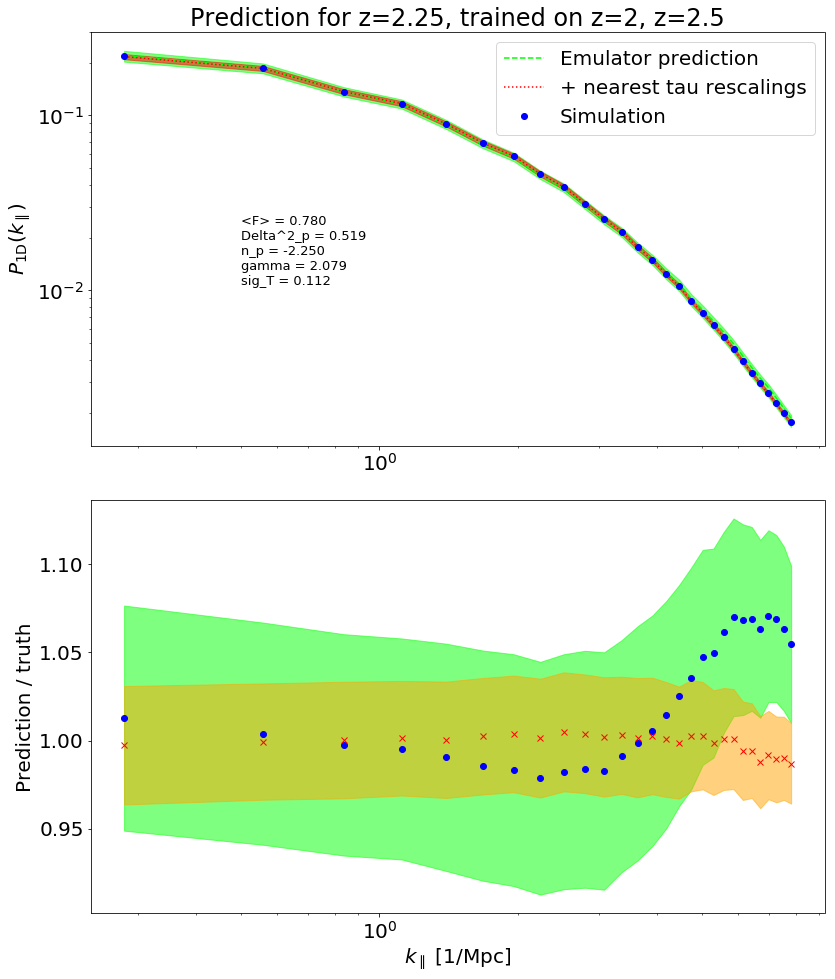

In [12]:
## Plot and compare with truth
plt.figure(figsize=[12,14])
plt.subplot(2,1,1)
plt.title("Prediction for z=2.25, trained on z=2, z=2.5")
plt.plot(k_test,pred_notau,color="lime",linestyle="dashed",label="Emulator prediction")
plt.fill_between(k_test,(pred_notau+np.sqrt(np.diag(err_notau))),
            (pred-np.sqrt(np.diag(err_notau))),alpha=0.5,color="lime")
plt.plot(k_test,pred,color="red",linestyle="dotted",label="+ nearest tau rescalings")
plt.fill_between(k_test,(pred+np.sqrt(np.diag(err))),
            (pred-np.sqrt(np.diag(err))),alpha=0.5,color="red")
plt.plot(k_test,truth.data[0]["p1d_Mpc"][1:(len(k_test)+1)],marker="o",
         color="blue",label="Simulation",linestyle="None")
plt.yscale("log")
plt.ylabel(r"$P_{\rm{1D}}(k_\parallel)$")
plt.xscale("log")
plt.legend()
plt.text(0.5,pred[0]/20,"<F> = %.3f \nDelta^2_p = %.3f \nn_p = %.3f \ngamma = %.3f \nsig_T = %.3f" % (testModel["mF"],testModel["Delta2_p"],testModel["n_p"],testModel["gamma"],testModel["sigT_Mpc"]),
                 fontsize=13)
plt.subplot(2,1,2)
plt.plot(k_test,pred_notau/truth.data[0]["p1d_Mpc"][1:(len(k_test)+1)],color="blue",marker="o",linestyle="None")
plt.fill_between(k_test,(pred_notau+np.sqrt(np.diag(err_notau)))/truth.data[0]["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_notau-np.sqrt(np.diag(err_notau)))/truth.data[0]["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color="lime")
plt.plot(k_test,pred/truth.data[0]["p1d_Mpc"][1:(len(k_test)+1)],color="red",marker="x",linestyle="None")
plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/truth.data[0]["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/truth.data[0]["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color="orange")
plt.xscale("log")
plt.ylabel("Prediction / truth")
plt.xlabel(r"$k_\parallel$ [1/Mpc]")
plt.tight_layout()
plt.savefig("redshift_prediction.png")